Practice 12 
## Week 11 Lab (DBSCAN)
### COSC 3337 Dr. Rizk

About The Data
We'll be using the Customer Dataset from kaggle for this lab, but feel free to follow along with your own dataset. The dataset contains the following attributes:

* CustomerID
* Genre
* Age
* AnnualIncome(k$)
* Spending_Score

Our goal is to group/cluster these customers.

**Note: This is the same data as week 10 lab.**

## DBSCAN vs. K-Means
K-Means clustering may cluster loosely related observations together. Every observation becomes a part of some cluster eventually, even if the observations are scattered far away in the vector space. Since clusters depend on the mean value of cluster elements, each data point plays a role in forming the clusters. A slight change in data points might affect the clustering outcome. This problem is greatly reduced in DBSCAN due to the way clusters are formed. This is usually not a big problem unless we come across some odd shape data.

Another challenge with k-means is that you need to specify the number of clusters (“k”) in order to use it. Most of the time, we won’t know what a reasonable k value is from the start.

What’s nice about DBSCAN is that you don’t have to specify the number of clusters to use it. All you need is a function to calculate the distance between values and some guidance for what amount of distance is considered “close”. DBSCAN also produces more reasonable results than k-means across a variety of different distributions. The below figure illustrates the fact:



## How The Algorithm Creates Clusters
The algorithm start by picking a point x from your dataset at random and assign it to a cluster 1. Then it counts how many points are located within the ε (epsilon) distance from x. If this quantity is greater than or equal to minPoints (n), then we consider it as a core point. Then it will pull out all these ε-neighbours to the same cluster 1. It will then examine each member of cluster 1 and find their respective ε-neighbours. If some member of cluster 1 has n or more ε-neighbours, it will expand cluster 1 by adding those ε-neighbours to the cluster. It will continue expanding cluster 1 until there are no more examples to put in it. In the latter case, it will pick another point from the dataset not belonging to any cluster and put it to cluster 2. It will continue like this until all examples either belong to some cluster or are marked as outliers.

There are three types of points after the DBSCAN clustering is complete:

* Core: This is a point that has at least minPoints points within distance ε from itself.
* Border: This is a point that has at least one Core point at a distance ε.
* Noise: This is a point that is neither a Core nor a Border. And it has less than minPoints points within distance ε from itself.

For a more in depth cover of DBSCAN, please refer back to the lecture video or slides.

## Implementation
Similarly to the K Means lab, we won't perform much data exploration and jump to implementation, but you're welcome to explore this data as much as you'd like, or your own if working with a different dataset.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 5
sns.set_style('darkgrid')

Let's first load the data into a pandas DataFrame. We'll drop customer id right away since it provides no valuable information.

In [5]:
customer_df = pd.read_csv('customers.csv')
customer_df.drop(['CustomerID'], axis=1, inplace=True)
customer_df.head()

,Genre,Age,Annual_Income_(k$),Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


calling **.info()** we see that there are no missing values in this dataset since there are 200 entries in total and 200 non-null entries in each column.

In [6]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Genre               200 non-null    object
 1   Age                 200 non-null    int64 
 2   Annual_Income_(k$)  200 non-null    int64 
 3   Spending_Score      200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [20]:
print(customer_df.dtypes)

Genre                 object
Age                    int64
Annual_Income_(k$)     int64
Spending_Score         int64
dtype: object


In [17]:
# the sum of all null
print(customer_df.isnull().sum())

Genre                 0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64


In [19]:
# check for duplicates 
duplicates = customer_df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# drop duplicates
customer_df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


In [11]:
# sns.heatmap(customer_df.corr(), annot=True)
# plt.show()

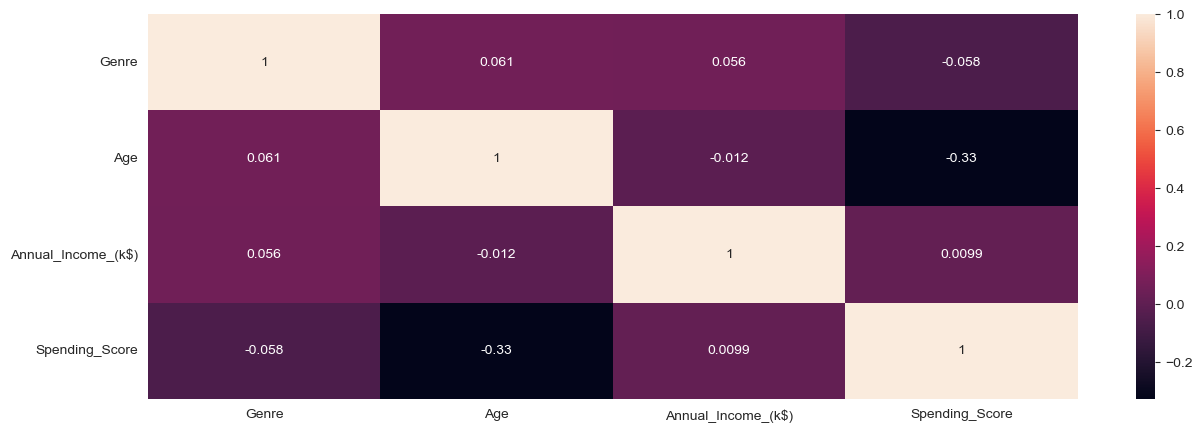

In [9]:
# instead of dropping the genre symmetric variable i will encode it instead
from sklearn.preprocessing import LabelEncoder

# encode categorical variables
customer_df_encoded = customer_df.copy()
for column in customer_df_encoded.select_dtypes(include=['object']).columns:
    customer_df_encoded[column] = LabelEncoder().fit_transform(customer_df_encoded[column])

    
# correlation heat matrix
corr = customer_df_encoded.corr()

sns.heatmap(corr, annot=True)
plt.show()

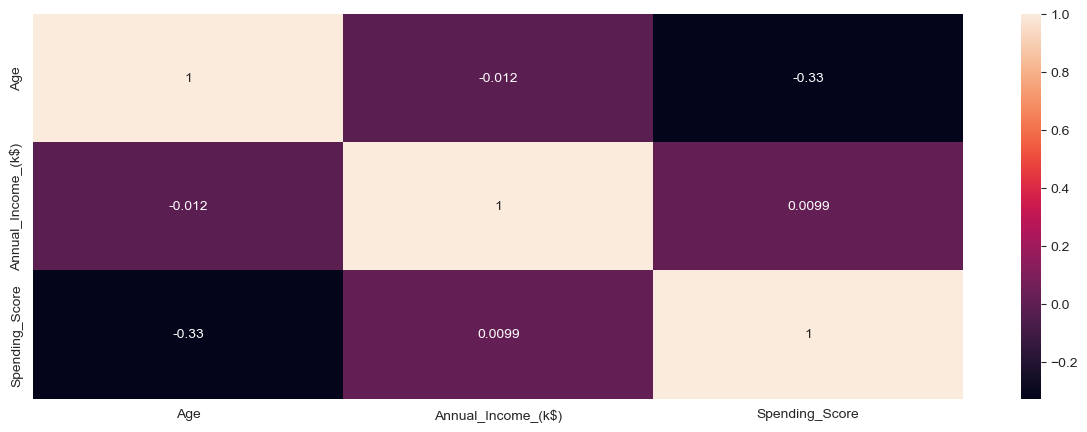

In [10]:
# droping non- numerical columns

# Select only numeric columns
numeric_df = customer_df.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr = numeric_df.corr()

# Create a heatmap
sns.heatmap(corr, annot=True)
plt.show()

No signs of significant multicollinarity

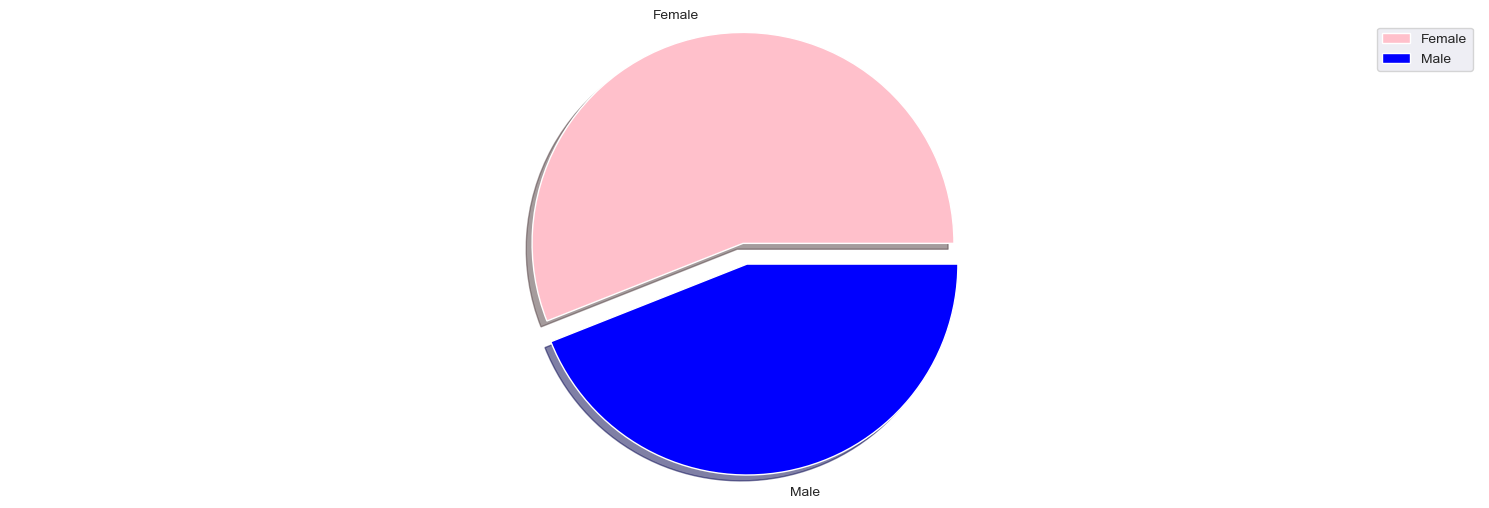

In [12]:
plt.pie(customer_df['Genre'].value_counts(), labels=['Female','Male'], colors=['Pink','Blue'], shadow=True,
        explode=[0,0.1])
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
plt.pie(customer_df['Genre'].value_counts(), labels=['Female','Male'], colors=['Pink','Blue'], shadow=True,
        explode=[0,0.1])
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

In [29]:
# Calculate the value counts for the 'Genre' column
genre_counts = customer_df['Genre'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(genre_counts, labels=genre_counts.index, colors=['Pink', 'Blue'], shadow=True,
        explode=[0, 0.1], startangle=90, 'autopct='%1.1f%%'' , wedgeprops={'edgecolor': 'black'})


SyntaxError: invalid decimal literal (220206297.py, line 6)

Our dataset seems roughly well balanced, with slightly more female than male observations.

Just as in lab 10 (K Means), we'll go ahead and only work with 2 variables (spending score and income) so that we can visualize our clusters in the end. However, you're free to use more than 2 variables if you're working with your own dataset.

In [13]:
# Saving only Spending_Score and income values into X.
X = customer_df.iloc[:, [2, 3]].values

We're now ready to create our model with with eps=3, min_samples=4, and metric='euclidean', and run the X vector we created earlier with spending score and income through to get our predictions.

In [14]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3, min_samples=4, metric='euclidean')
db.fit(X)

DBSCAN(eps=3, min_samples=4)

We can access the labels as follows:

In [15]:
db.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1,  0, -1,  0, -1,  0,  0,
       -1,  0, -1, -1,  0, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  2,
        3,  3, -1,  3, -1, -1,  4, -1, -1, -1,  4,  5,  4, -1,  4,  5, -1,
        5,  4, -1,  4,  5, -1, -1,  6, -1, -1, -1,  7, -1,  6, -1,  6, -1,
        7, -1,  6, -1,  7, -1,  7, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        8, -1,  8, -1,  8, -1,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

We have a total of 9 different clusters. We can go ahead and make our predictions and visualize them as follows:

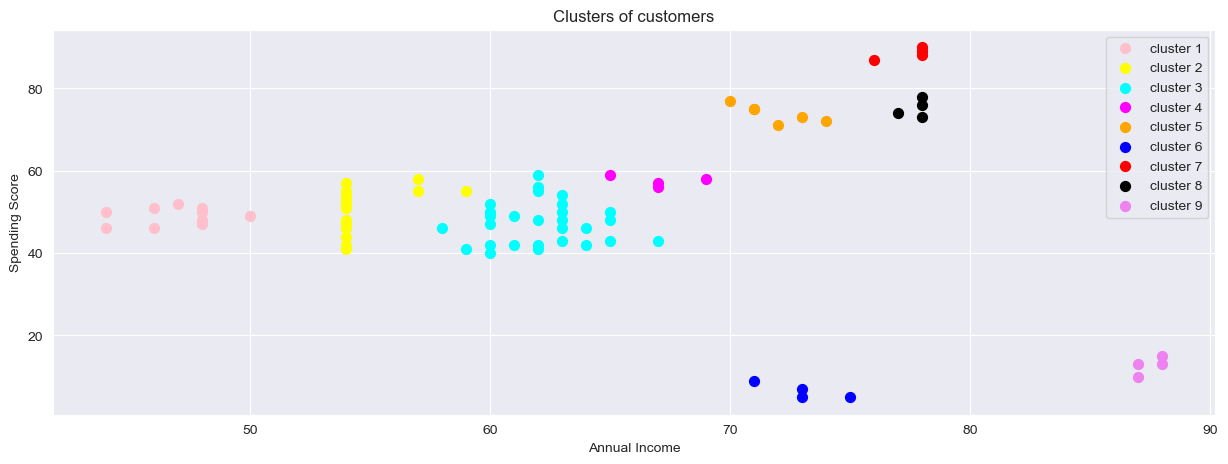

In [16]:
y_preds = db.fit_predict(X)

plt.scatter(X[y_preds == 0, 0], X[y_preds == 0, 1], s = 50, c = 'pink', label='cluster 1')
plt.scatter(X[y_preds == 1, 0], X[y_preds == 1, 1], s = 50, c = 'yellow', label='cluster 2')
plt.scatter(X[y_preds == 2, 0], X[y_preds == 2, 1], s = 50, c = 'cyan', label='cluster 3')
plt.scatter(X[y_preds == 3, 0], X[y_preds == 3, 1], s = 50, c = 'magenta', label='cluster 4')
plt.scatter(X[y_preds == 4, 0], X[y_preds == 4, 1], s = 50, c = 'orange', label='cluster 5')
plt.scatter(X[y_preds == 5, 0], X[y_preds == 5, 1], s = 50, c = 'blue', label='cluster 6')
plt.scatter(X[y_preds == 6, 0], X[y_preds == 6, 1], s = 50, c = 'red', label='cluster 7')
plt.scatter(X[y_preds == 7, 0], X[y_preds == 7, 1], s = 50, c = 'black', label='cluster 8')
plt.scatter(X[y_preds == 8, 0], X[y_preds == 8, 1], s = 50, c = 'violet', label='cluster 9')
plt.title('Clusters of customers')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

Congrats! 🙂 You know know how to apply DBSCAN in sklearn. Try repeating the lab steps on your own data for practice. Also, check out lab 10 and see how our results compare to K-Means.